# Notes:


This notebook creates figures for our IllustrisTNG paper. It builds upon work in

- raven:/u/cwalker/Illustris_FRB_Project/Test_illustris_density_structures.ipynb
- raven:/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/SCRIPT_Cel_Auto.py

# Imports:

In [1]:
import os
import yt
import sys
import h5py
import trident
import matplotlib

import numpy as np
import illustris_python as il

import matplotlib.patches as mpatches
from trident import LightRay
from artale_constants import *
from matplotlib.colors import LogNorm
from yt.utilities.cosmology import Cosmology

from astropy import units as u
from astropy import constants as c
from matplotlib import pyplot as plt
from yt.visualization.fixed_resolution import FixedResolutionBuffer as FRB

#matplotlib.use('Agg')

#from matplotlib import pyplot as plt



/raven/u/cwalker/virtual_environments/yt-git/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /u/cwalker/.config/yt/ytrc is deprecated in favor of /u/cwalker/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


# Plots

## Structure boundaries

Based on paper: 

In [ ]:
#Load TNG data

TNG_data='/virgotng/universe/IllustrisTNG/TNG100-3/output/snapdir_099/snap_099.0.hdf5'
TNG_ds=yt.load(TNG_data)
TNG_ds.index


yt : [INFO     ] 2023-03-22 17:20:24,374 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2023-03-22 17:20:24,479 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2023-03-22 17:20:24,480 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-03-22 17:20:24,483 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-03-22 17:20:24,484 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2023-03-22 17:20:24,485 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-03-22 17:20:24,486 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2023-03-22 17:20:24,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2023-03-22 17:20:24,488 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2023-03-22 17:20:24,489 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-03-22 17:20:24,490 Parameters: hubble_consta

In [28]:
#extract all data
TNG_ad = TNG_ds.all_data()

#get the coordinates of all baryonic matter particles
TNG_Bcoords = TNG_ad[("PartType0","Coordinates")]

#get the baryonic mass densities
#TNG_Density = TNG_ad[("PartType0","Density")]

#get the baryonic masses
TNG_Mass = TNG_ad[("PartType0","Masses")]

# get the subfindDMDensities
TNG_SubDM = TNG_ad[("PartType0","SubfindDMDensity")]
print(TNG_SubDM)

#get the subfindDensity
TNG_Sub = TNG_ad[("PartType0","SubfindDensity")]
print(TNG_Sub)

[1.11098506e-03 3.27121583e-03 1.02324551e-03 ... 7.68346524e-08
 1.13918741e-08 4.61223209e-07] dimensionless
[1.28246774e-03 3.64398304e-03 1.14714028e-03 ... 8.32019538e-08
 1.45094265e-08 5.28491967e-07] dimensionless


In [29]:
#get the critical density of the universe
#define gravitational constant, g as in astropy

from yt.utilities.cosmology import Cosmology
co=Cosmology()

grav=TNG_ds.quan(6.6743e-11,'m**3/(kg*s**2)')
H=co.hubble_parameter(0).in_units('km/s/Mpc')
print('grav={0}'.format(grav))
print('H0 = {0}'.format(H))

#create thee critical density of the universe: note: is my inteerp of H correct?
dens_crit = ((3 * H**2)/(8*np.pi* grav))#.in_units('h**2/(code_length**3/(Msun*s**2))')
print ('critical density is: {0}'.format(dens_crit))
print('critical density in kg/m^3: {0}'.format(dens_crit.in_units('kg/m**3')))


grav=6.6743e-11 m**3/(kg*s**2)
H0 = 71.0 km/(Mpc*s)
critical density is: 9.468720094206941e-27 kg/m**3
critical density in kg/m^3: 9.468720094206941e-27 kg/m**3


In [30]:
#initialise binning

mybins=np.linspace(-3,7,101)
mybins=np.linspace(-3,7,501) #edit 14/06/2022 : more bins to make final plot better

my_mass_sum = np.zeros_like(mybins)

my_checkdata = np.log10(TNG_SubDM*TNG_ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit)

#sort into bins
bin_indexes=np.digitize(my_checkdata,mybins)


In [31]:
#do the actual binning
for i in range(len(my_checkdata)):
    bin_index=bin_indexes[i]
    my_mass_sum[bin_index]+=TNG_Mass[i].v

501
88935326


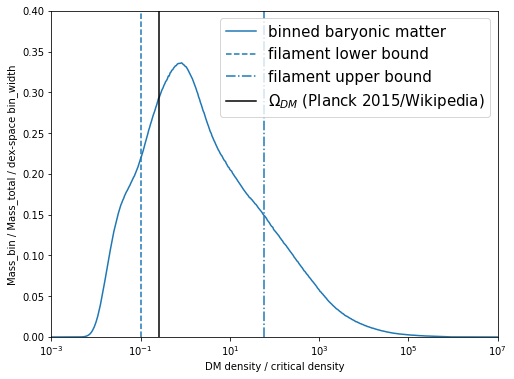

In [32]:
print(my_mass_sum.size)
print(my_checkdata.size)

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)

ax.set_ylabel('Mass_bin / Mass_total / dex-space bin_width')

ax.set_xlabel('DM density / critical density')
ax.set_xscale('log')
ax.set_xlim([1e-3,1e7])
ax.set_ylim([0,0.4])


ax.plot(10**mybins,my_mass_sum/np.sum(my_mass_sum)/(mybins[1]-mybins[0]),label='binned baryonic matter')
ax.axvline(0.1,0,1,linestyle='--',label='filament lower bound')
ax.axvline(57,0,1,linestyle='-.',label='filament upper bound')
ax.axvline(0.2589,0,1,color='k',label='$\Omega_{DM}$ (Planck 2015/Wikipedia)')

plt.legend(fontsize=15)
plt.savefig('Haiderplot.png')
plt.show()

# Artale comparison

In [33]:
def getField(snapFile,partType,fieldName,toDouble=False):
        if toDouble==False:
                return snapFile[partType][fieldName][:]
        if toDouble==True:
                return snapFile[partType][fieldName][:].astype('f8')


def gadgetDens2SI(dens):
        return dens*1E10*Msol_si/hubble/(kpc_si/hubble)**3

In [34]:
#############################    
#load all celeste paper data#
#############################

#voids
V3001_dat = np.loadtxt('/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/MassFraction_VoidsL205n2500TNG.dat',comments='#',skiprows=2) #TNG300-1
V3001_sn = V3001_dat[:,0] #snapshot number
V3001_mf = V3001_dat[:,2] #mass fraction

V1001_dat = np.loadtxt('/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/MassFraction_VoidsL75n1820TNG.dat',comments='#',skiprows=2) #TNG100-1
V1001_sn = V1001_dat[:,0] #snapshot number
V1001_mf = V1001_dat[:,2] #mass fraction

#filaments
F3001_dat = np.loadtxt('/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/MassFraction_FilamentsL205n2500TNG.dat',comments='#',skiprows=2) #TNG300-1
F3001_sn = F3001_dat[:,0] #snapshot number
F3001_mf = F3001_dat[:,2] #mass fraction

F1001_dat = np.loadtxt('/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/MassFraction_FilamentsL75n1820TNG.dat',comments='#',skiprows=2) #TNG100-1
F1001_sn = F1001_dat[:,0] #snapshot number
F1001_mf = F1001_dat[:,2] #mass fraction

#halos
H3001_dat = np.loadtxt('/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/MassFraction_HaloesL205n2500TNG.dat',comments='#',skiprows=2) #TNG300-1
H3001_sn = H3001_dat[:,0] #snapshot number
H3001_mf = H3001_dat[:,2] #mass fraction

H1001_dat = np.loadtxt('/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/MassFraction_HaloesL75n1820TNG.dat',comments='#',skiprows=2) #TNG100-1
H1001_sn = H1001_dat[:,0] #snapshot number
H1001_mf = H1001_dat[:,2] #mass fraction

celeste_redshifts = [] #initialise array to hold redshifts

for i in range(len(V3001_sn)): #loop over snapshots
    
    celeste_snapshot = int(V3001_sn[i]) #get snapshot number
    data_id = 'TNG100-1'
    basepath = '/virgotng/universe/IllustrisTNG/'+data_id+'/output/'
    header=il.groupcat.loadHeader(basepath,celeste_snapshot) #load header
    celeste_redshifts.append(header['Redshift']) #apped redshift to array

print(celeste_redshifts)

[2.220446049250313e-16, 0.5030475232448832, 0.9972942257819404, 2.0020281392528516, 3.008131071630377, 4.0079451114652676, 4.995933468164624, 6.0107573988449, 7.005417045544533, 8.012172948865935]


In [53]:
#######
#begin#
#######

#get TNG run locations
simStrings = os.listdir('/virgotng/universe/IllustrisTNG/') #get all directories
print(simStrings)

simStrings = [i for i in simStrings if i=='L205n2500TNG'] #just do TNG300-1
#simStrings = [i for i in simStrings if i[-3:]=='TNG'] #extract only full runs
print(simStrings)

#get number of chunks for each run

simChunks = [len([i for i in os.listdir('/virgotng/universe/IllustrisTNG//{0}/output/snapdir_099/'.format(j))]) for j in simStrings]
print(simChunks)

#sort both lists to do shortest first
simStrings_sorted = [x for _, x in sorted(zip(simChunks, simStrings))]
simChunks_sorted = sorted(simChunks)
print(simStrings_sorted)
print(simChunks_sorted)

 
    
for run in range(len(simStrings)):
    simString = simStrings_sorted[run]
    chunks = np.arange(0,simChunks_sorted[run],1)

    #simString = 'L205n625TNG'
    #chunks = np.arange(0,16,1)
    snapshots = [99,91,84,78,72,67,59,50,40,33,25,21,17]#,13,11,8,6,4,3,2]

    #simString = "L205n2500TNG" #large volume
    #nFiles = 600

    snapshotPath="/virgotng/universe/IllustrisTNG/"+simString+"/output"
    ######################################
    #initialise arrays that hold all data#
    ######################################

    #redshift array
    allsnaps_redshifts=[]

    #baryon arrays
    #PartType0 (gas)
    allsnaps_tot_PT0_arr = []
    allsnaps_hal_PT0_arr = []
    allsnaps_fil_PT0_arr = []
    allsnaps_voi_PT0_arr = []
    #PartType4 (stars)
    allsnaps_tot_PT4_arr = []
    allsnaps_hal_PT4_arr = []
    allsnaps_fil_PT4_arr = []
    allsnaps_voi_PT4_arr = []

    #check arrays
    allsnaps_dens_crit_array = []
    allsnaps_m_p_array = []

    ################################
    #loop over snapshots and chunks#
    ################################

    for i in range(len(snapshots)):

        ######################################################
        #initialise arrays that hold individual snapshot data#
        ######################################################

        #redshift array
        redshifts=[]

        #baryon arrays
        #PartType0 (gas)
        tot_PT0_arr = []
        hal_PT0_arr = []
        fil_PT0_arr = []
        voi_PT0_arr = []
        #PartType4 (stars)
        tot_PT4_arr = []
        hal_PT4_arr = []
        fil_PT4_arr = []
        voi_PT4_arr = []

        #check arrays
        dens_crit_array = []
        m_p_array = []

        for j in range(len(chunks)):

            ###########################
            #select snapshot and chunk#
            ###########################

            snapshot = snapshots[i]
            chunk = chunks[j]
            print('processsing snapshot {0:02d}, chunk {1}'.format(snapshot,chunk))

            ######################
            #load snapshot header#
            ######################

            print('loading snapshot header')
            basepath = '/virgotng/universe/IllustrisTNG/'+simString+'/output/'#'/virgo/simulations/IllustrisTNG/TNG100-3/output/'
            header=il.groupcat.loadHeader(basepath,snapshot)
            print('header loaded.')


            #simString = "L205n2500TNG" #large volume
            #nFiles = 600
            #snapshotPath="/n/holylfs/LABS/hernquist_lab/IllustrisTNG/Runs/"+simString+"/output"

            fname = snapshotPath+'/snapdir_'+str(snapshot).zfill(3)+'/'+'snap_'+str(snapshot).zfill(3)+'.'+str(j)+'.hdf5'
            print(fname)

            snapFile = h5py.File(fname,'r')       

            ########################################################
            #extract redshift from header, append to redshift array#
            ########################################################

            redshifts.append(header['Redshift'])

            #####################
            #load Illustris data#
            #####################

            #data='/n/holylfs/LABS/hernquist_lab/IllustrisTNG/Runs/L205n625TNG/output/snapdir_0{0:02d}/snap_0{0:02d}.{1}.hdf5'.format(snapshot,chunk)
            #print('loading dataset: {0}'.format(data))
            #ds=yt.load(data)
            #print('data loaded.')

            ####################################
            #define proton mass in solar masses#
            ####################################

            #print('calculating proton mass:')
            #m_p = ds.quan((c.m_p).to(u.solMass).value,'Msun')
            #print ('proton mass: {0}'.format(m_p))
            #m_p_array.append(m_p)

            #ds.index

            ############################################
            #calculate critical density of the Universe#
            ############################################

            print('Calculating critical density of the Universe')
            #co=Cosmology()
            #grav=ds.quan(6.6743e-11,'m**3/(kg*s**2)')
            #H=co.hubble_parameter(0).in_units('km/s/Mpc')
            #print('grav={0}'.format(grav))
            #print('H0 = {0}'.format(H))
            #dens_crit = ((3 * H**2)/(8*np.pi* grav))#.in_units('h**2/(code_length**3/(Msun*s**2))')
            #print ('critical density is: {0}'.format(dens_crit))
            #print('critical density in kg/m^3: {0}'.format(dens_crit.in_units('kg/m**3')))
            #dens_crit_array.append(dens_crit)
            dens_crit = 8.61975454419e-27 #Celeste:extracted from "constant.py"
            hubble = 0.677
            #ad = ds.all_data()

            ##########################################################
            #convert dark matter density to units of critical density#
            ##########################################################

            #PartType0 (gas)
            #dark_units_PT0 = ad['PartType0','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit
            gasMass = getField(snapFile,'PartType0','Masses',toDouble=True)
            #dark_units_PT0 = getField(snapFile,'PartType0','SubfindDMDensity',toDouble=True)*1E10/hubble/dens_crit
            DMDens0 = getField(snapFile,'PartType0','SubfindDMDensity',toDouble=True)
            DMDens0 = gadgetDens2SI(DMDens0)/dens_crit
            #PartType4 (stars)
            #dark_units_PT4 = ad['PartType4','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit
            stellarMass = getField(snapFile,'PartType4','Masses',toDouble=True)
            #dark_units_PT4 = getField(snapFile,'PartType4','SubfindDMDensity',toDouble=True)*1E10/hubble/dens_crit
            DMDens4 = getField(snapFile,'PartType4','SubfindDMDensity',toDouble=True)
            DMDens4 = gadgetDens2SI(DMDens4)/dens_crit 
            ###############################################################
            #create Large-Scale Structure (LSS) masks for each matter type#
            ###############################################################

            mask0 = np.logical_and(DMDens0 >= 1E-11, DMDens0 < 1)
            mask4 = np.logical_and(DMDens4 >= 1E-11, DMDens4 < 1)
            print("Check something outside", len(DMDens4[mask4]), len(DMDens0[mask0]))

            #PartType0 (gas)
            voi_mask_PT0 = DMDens0 < 0.1
            fil_mask_PT0 = np.logical_and(DMDens0 >= 0.1, DMDens0 < 57)#CELESTE:CORRECTED
            hal_mask_PT0 = DMDens0 >= 57 
            #PartType4 (stars)
            voi_mask_PT4 = DMDens4 < 0.1
            fil_mask_PT4 = np.logical_and(DMDens4 >= 0.1, DMDens4 < 57)#CELESTE:CORRECTED
            hal_mask_PT4 = DMDens4 >= 57

            ##########################################################
            #calculate mass in each LSS for each baryonic matter type#
            ##########################################################

            #PartType0 (gas)
            tot_PT0 = np.sum(gasMass) #np.sum(ad['PartType0','Masses'])
            hal_PT0 = np.sum(gasMass[hal_mask_PT0])#np.sum(ad['PartType0','Masses'][hal_mask_PT0])
            fil_PT0 = np.sum(gasMass[fil_mask_PT0])#np.sum(ad['PartType0','Masses'][fil_mask_PT0])
            voi_PT0 = np.sum(gasMass[voi_mask_PT0])#np.sum(ad['PartType0','Masses'][voi_mask_PT0])
            #PartType4 (stars)
            tot_PT4 = np.sum(stellarMass)#np.sum(ad['PartType4','Masses'])
            hal_PT4 = np.sum(stellarMass[hal_mask_PT4])#np.sum(ad['PartType4','Masses'][hal_mask_PT4])
            fil_PT4 = np.sum(stellarMass[fil_mask_PT4])#np.sum(ad['PartType4','Masses'][fil_mask_PT4])
            voi_PT4 = np.sum(stellarMass[voi_mask_PT4])#np.sum(ad['PartType4','Masses'][voi_mask_PT4])

            ##########################
            #append results to arrays#
            ##########################

            #PartType0 (gas)
            tot_PT0_arr.append(tot_PT0)
            hal_PT0_arr.append(hal_PT0)
            fil_PT0_arr.append(fil_PT0) 
            voi_PT0_arr.append(voi_PT0) 
            #PartType4 (gas)
            tot_PT4_arr.append(tot_PT4)
            hal_PT4_arr.append(hal_PT4)
            fil_PT4_arr.append(fil_PT4) 
            voi_PT4_arr.append(voi_PT4)

        ######################################################    
        #append all results for a snapshot to the final array#
        ######################################################

        #PartType0 (gas)
        allsnaps_tot_PT0_arr.append(tot_PT0_arr)
        allsnaps_hal_PT0_arr.append(hal_PT0_arr)
        allsnaps_fil_PT0_arr.append(fil_PT0_arr) 
        allsnaps_voi_PT0_arr.append(voi_PT0_arr) 
        #PartType4 (gas)
        allsnaps_tot_PT4_arr.append(tot_PT4_arr)
        allsnaps_hal_PT4_arr.append(hal_PT4_arr)
        allsnaps_fil_PT4_arr.append(fil_PT4_arr) 
        allsnaps_voi_PT4_arr.append(voi_PT4_arr)    

        allsnaps_m_p_array.append(m_p_array)
        allsnaps_dens_crit_array.append(dens_crit_array)
        allsnaps_redshifts.append(redshifts)


        print('filled baryon arrays')


    #########################
    #convert to numpy arrays#
    #########################

    #tot_PT0_arr=np.array(tot_PT0_arr)
    #hal_PT0_arr=np.array(hal_PT0_arr)
    #fil_PT0_arr=np.array(fil_PT0_arr)
    #voi_PT0_arr=np.array(voi_PT0_arr)

    #tot_PT4_arr=np.array(tot_PT4_arr)
    #hal_PT4_arr=np.array(hal_PT4_arr)
    #fil_PT4_arr=np.array(fil_PT4_arr)
    #voi_PT4_arr=np.array(voi_PT4_arr)

    allsnaps_tot_PT0_arr = np.array(allsnaps_tot_PT0_arr)
    allsnaps_hal_PT0_arr = np.array(allsnaps_hal_PT0_arr)
    allsnaps_fil_PT0_arr = np.array(allsnaps_fil_PT0_arr)
    allsnaps_voi_PT0_arr = np.array(allsnaps_voi_PT0_arr)

    allsnaps_tot_PT4_arr = np.array(allsnaps_tot_PT4_arr)
    allsnaps_hal_PT4_arr = np.array(allsnaps_hal_PT4_arr)
    allsnaps_fil_PT4_arr = np.array(allsnaps_fil_PT4_arr)
    allsnaps_voi_PT4_arr = np.array(allsnaps_voi_PT4_arr)

    allsnaps_redshifts = np.array(allsnaps_redshifts)
    allsnaps_m_p_array = np.array(allsnaps_m_p_array)
    allsnaps_dens_crit_array = np.array(allsnaps_dens_crit_array)

    print("critical_density", allsnaps_dens_crit_array)
    ###############
    #check lengths#
    ###############

    print(len(snapshots))
    print(allsnaps_redshifts.shape)
    print(allsnaps_m_p_array.shape)
    print(allsnaps_dens_crit_array.shape)
    print(allsnaps_hal_PT0_arr.shape)
    print(allsnaps_fil_PT0_arr.shape)
    print(allsnaps_voi_PT0_arr.shape)
    print(allsnaps_hal_PT4_arr.shape)
    print(allsnaps_fil_PT4_arr.shape)
    print(allsnaps_voi_PT4_arr.shape)


    print(allsnaps_tot_PT0_arr.sum(axis=1).shape) #summing chunks for each snapshot
    print(allsnaps_redshifts.mean(axis=1)) #recovering the redshift for each snapshot


    ##################################################
    #for each of the 13 snapshots, sum the masses in #
    #each of the 7 simulation subchunks to obtain    #
    #the total mass for the entire redshift          #
    ##################################################

    tot_PT0_arr_summed = allsnaps_tot_PT0_arr.sum(axis=1)
    hal_PT0_arr_summed = allsnaps_hal_PT0_arr.sum(axis=1)
    fil_PT0_arr_summed = allsnaps_fil_PT0_arr.sum(axis=1)
    voi_PT0_arr_summed = allsnaps_voi_PT0_arr.sum(axis=1)

    tot_PT4_arr_summed = allsnaps_tot_PT4_arr.sum(axis=1)
    hal_PT4_arr_summed = allsnaps_hal_PT4_arr.sum(axis=1)
    fil_PT4_arr_summed = allsnaps_fil_PT4_arr.sum(axis=1)
    voi_PT4_arr_summed = allsnaps_voi_PT4_arr.sum(axis=1)

    print(allsnaps_hal_PT0_arr.sum(axis=1).shape)


    ####################################################
    #for each of the 13 snapshots, sum the masses in   #
    #PT0 and PT4 to obtain the total baryonic mass for #
    #each redshift                                     #
    ####################################################

    tot_PT14_arr_summed = tot_PT0_arr_summed + tot_PT4_arr_summed
    hal_PT14_arr_summed = hal_PT0_arr_summed + hal_PT4_arr_summed
    fil_PT14_arr_summed = fil_PT0_arr_summed + fil_PT4_arr_summed
    voi_PT14_arr_summed = voi_PT0_arr_summed + voi_PT4_arr_summed

    print(hal_PT14_arr_summed.shape)


    #######################
    #create mass fractions#
    #######################

    #hal_frac = (hal_PT0_arr + hal_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)
    #fil_frac = (fil_PT0_arr + fil_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)
    #voi_frac = (voi_PT0_arr + voi_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)


    hal_frac = (hal_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)
    fil_frac = (fil_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)
    voi_frac = (voi_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)

    print(hal_frac.shape)

    #####################
    #plot mass fractions#
    #####################

    fig=plt.figure(figsize=(12,9))

    ax1=fig.add_subplot(111)
    ax1.set_xlabel('z',fontsize=15)
    ax1.set_ylabel('mf',fontsize=15)
    ax1.set_yscale('log')
    ax1.set_ylim([6E-3,1])
    ax1.set_xlim([0.,6.])

    ax1.plot(celeste_redshifts,H1001_mf,color='r',marker='o',lw='3',alpha=0.5,label='Paper Halos (TNG100-1)')
    ax1.plot(celeste_redshifts,H3001_mf,color='r',marker='o',ls='-.',alpha=0.5,lw='3',label='Paper Halos (TNG300-1)')

    ax1.plot(celeste_redshifts,F1001_mf,color='b',marker='o',lw='3',alpha=0.5,label='Paper Filaments (TNG100-1)')
    ax1.plot(celeste_redshifts,F3001_mf,color='b',marker='o',ls='-.',alpha=0.5,lw='3',label='Paper Filaments (TNG300-1)')

    ax1.plot(celeste_redshifts,V1001_mf,color='g',marker='o',lw='3',alpha=0.5,label='Paper Voids (TNG100-1)')
    ax1.plot(celeste_redshifts,V3001_mf,color='g',marker='o',ls='-.',alpha=0.5,lw='3',label='Paper Voids (TNG300-1)')
    
    ax1.plot((allsnaps_redshifts.mean(axis=1))[0:13],hal_frac[0:13],label='{0} halo'.format(simString))
    ax1.plot((allsnaps_redshifts.mean(axis=1))[0:13],fil_frac[0:13],label='{0} filament'.format(simString))
    ax1.plot((allsnaps_redshifts.mean(axis=1))[0:13],voi_frac[0:13],label='{0} void'.format(simString))


    ax1.legend(fontsize=15)
    plt.savefig('evolving_mass_fraction_{0}.png'.format(simString))

['L35n270TNG', 'readme.txt', 'TNG50-4', 'TNG300-2', 'L35n2160TNG_DM', 'TNG300-2-Dark', 'L35n270TNG_DM', 'L75n455TNG_NR', 'L35n540TNG', 'L75n1820TNG_NR', 'L75n455TNG', 'TNG300-1', 'L35n2160TNG', 'L75n910TNG', 'L75n1820TNG_DM', 'TNG100-2-NR', 'TNG100-1', 'TNG50-3-Dark', 'TNG50-4-Dark', 'TNG100-3', 'L75n455TNG_DM', 'L75n910TNG_DM', 'TNG50-3', 'TNG50-2-Dark', 'TNG50-2', 'InitialConditions', 'L75n455TNG_UVB', 'TNG50-1-Dark', 'L205n2500TNG_DM', 'TNG100-2-Dark', 'L75n910TNG_NR', 'TNG100-3-Dark', 'TNG100-1-NR', 'TNG300-3-Dark', 'L205n625TNG', 'L205n1250TNG_DM', 'TNG300-1-Dark', 'L35n1080TNG', 'TNG300-3', 'L35n1080TNG_DM', 'TNG100-2', 'L75n1820TNG', 'L205n2500TNG', 'L205n1250TNG', 'L35n540TNG_DM', 'TNG100-3-NR', 'L205n625TNG_DM', 'TNG100-1-Dark', 'TNG50-1']
['L205n2500TNG']
[600]
['L205n2500TNG']
[600]
processsing snapshot 99, chunk 0
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.0.hdf5
Calculating critical density of the Univers

Check something outside 0 16
processsing snapshot 99, chunk 33
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.33.hdf5
Calculating critical density of the Universe
Check something outside 0 1
processsing snapshot 99, chunk 34
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.34.hdf5
Calculating critical density of the Universe
Check something outside 0 1
processsing snapshot 99, chunk 35
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.35.hdf5
Calculating critical density of the Universe
Check something outside 0 8
processsing snapshot 99, chunk 36
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.36.hdf5
Calculating critical density of the Universe
Check something outside 0 2
processsing snapshot 99, chunk 37
loading snapshot header
heade

processsing snapshot 99, chunk 69
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.69.hdf5
Calculating critical density of the Universe
Check something outside 0 14
processsing snapshot 99, chunk 70
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.70.hdf5
Calculating critical density of the Universe
Check something outside 0 14
processsing snapshot 99, chunk 71
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.71.hdf5
Calculating critical density of the Universe
Check something outside 0 16
processsing snapshot 99, chunk 72
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.72.hdf5
Calculating critical density of the Universe
Check something outside 0 19
processsing snapshot 99, chunk 73
loading snapshot header
header loaded.
/virgotng/unive

Check something outside 0 162
processsing snapshot 99, chunk 105
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.105.hdf5
Calculating critical density of the Universe
Check something outside 0 229
processsing snapshot 99, chunk 106
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.106.hdf5
Calculating critical density of the Universe
Check something outside 0 253
processsing snapshot 99, chunk 107
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.107.hdf5
Calculating critical density of the Universe
Check something outside 0 239
processsing snapshot 99, chunk 108
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.108.hdf5
Calculating critical density of the Universe
Check something outside 0 210
processsing snapshot 99, chunk 109
loading sna

Check something outside 0 12412
processsing snapshot 99, chunk 141
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.141.hdf5
Calculating critical density of the Universe
Check something outside 0 16938
processsing snapshot 99, chunk 142
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.142.hdf5
Calculating critical density of the Universe
Check something outside 0 22331
processsing snapshot 99, chunk 143
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.143.hdf5
Calculating critical density of the Universe
Check something outside 0 29361
processsing snapshot 99, chunk 144
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.144.hdf5
Calculating critical density of the Universe
Check something outside 0 38450
processsing snapshot 99, chunk 145
l

Check something outside 0 16075681
processsing snapshot 99, chunk 176
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.176.hdf5
Calculating critical density of the Universe
Check something outside 0 16324165
processsing snapshot 99, chunk 177
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.177.hdf5
Calculating critical density of the Universe
Check something outside 0 16364368
processsing snapshot 99, chunk 178
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.178.hdf5
Calculating critical density of the Universe
Check something outside 0 16738581
processsing snapshot 99, chunk 179
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.179.hdf5
Calculating critical density of the Universe
Check something outside 0 16356401
processsing snapshot 

Check something outside 0 15689327
processsing snapshot 99, chunk 211
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.211.hdf5
Calculating critical density of the Universe
Check something outside 0 15765892
processsing snapshot 99, chunk 212
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.212.hdf5
Calculating critical density of the Universe
Check something outside 0 16176196
processsing snapshot 99, chunk 213
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.213.hdf5
Calculating critical density of the Universe
Check something outside 0 15599215
processsing snapshot 99, chunk 214
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.214.hdf5
Calculating critical density of the Universe
Check something outside 0 15799666
processsing snapshot 

Check something outside 0 15358058
processsing snapshot 99, chunk 246
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.246.hdf5
Calculating critical density of the Universe
Check something outside 0 15059565
processsing snapshot 99, chunk 247
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.247.hdf5
Calculating critical density of the Universe
Check something outside 0 14830031
processsing snapshot 99, chunk 248
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.248.hdf5
Calculating critical density of the Universe
Check something outside 0 15008195
processsing snapshot 99, chunk 249
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.249.hdf5
Calculating critical density of the Universe
Check something outside 0 15007665
processsing snapshot 

Check something outside 0 16127420
processsing snapshot 99, chunk 281
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.281.hdf5
Calculating critical density of the Universe
Check something outside 0 16112698
processsing snapshot 99, chunk 282
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.282.hdf5
Calculating critical density of the Universe
Check something outside 0 15902958
processsing snapshot 99, chunk 283
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.283.hdf5
Calculating critical density of the Universe
Check something outside 0 15618559
processsing snapshot 99, chunk 284
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.284.hdf5
Calculating critical density of the Universe
Check something outside 0 15663210
processsing snapshot 

Check something outside 0 16003528
processsing snapshot 99, chunk 316
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.316.hdf5
Calculating critical density of the Universe
Check something outside 0 15940870
processsing snapshot 99, chunk 317
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.317.hdf5
Calculating critical density of the Universe
Check something outside 0 15828110
processsing snapshot 99, chunk 318
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.318.hdf5
Calculating critical density of the Universe
Check something outside 0 15783779
processsing snapshot 99, chunk 319
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.319.hdf5
Calculating critical density of the Universe
Check something outside 0 15818856
processsing snapshot 

Check something outside 0 16297705
processsing snapshot 99, chunk 351
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.351.hdf5
Calculating critical density of the Universe
Check something outside 0 16398678
processsing snapshot 99, chunk 352
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.352.hdf5
Calculating critical density of the Universe
Check something outside 0 16319702
processsing snapshot 99, chunk 353
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.353.hdf5
Calculating critical density of the Universe
Check something outside 0 16403068
processsing snapshot 99, chunk 354
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.354.hdf5
Calculating critical density of the Universe
Check something outside 0 16205396
processsing snapshot 

Check something outside 0 15816033
processsing snapshot 99, chunk 386
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.386.hdf5
Calculating critical density of the Universe
Check something outside 0 15850518
processsing snapshot 99, chunk 387
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.387.hdf5
Calculating critical density of the Universe
Check something outside 0 15888306
processsing snapshot 99, chunk 388
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.388.hdf5
Calculating critical density of the Universe
Check something outside 0 15914607
processsing snapshot 99, chunk 389
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.389.hdf5
Calculating critical density of the Universe
Check something outside 0 15952785
processsing snapshot 

Check something outside 0 16016003
processsing snapshot 99, chunk 421
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.421.hdf5
Calculating critical density of the Universe
Check something outside 0 16197049
processsing snapshot 99, chunk 422
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.422.hdf5
Calculating critical density of the Universe
Check something outside 0 16168363
processsing snapshot 99, chunk 423
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.423.hdf5
Calculating critical density of the Universe
Check something outside 0 16204821
processsing snapshot 99, chunk 424
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.424.hdf5
Calculating critical density of the Universe
Check something outside 0 15926327
processsing snapshot 

Check something outside 0 15948084
processsing snapshot 99, chunk 456
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.456.hdf5
Calculating critical density of the Universe
Check something outside 0 15698963
processsing snapshot 99, chunk 457
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.457.hdf5
Calculating critical density of the Universe
Check something outside 0 15543395
processsing snapshot 99, chunk 458
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.458.hdf5
Calculating critical density of the Universe
Check something outside 0 15938475
processsing snapshot 99, chunk 459
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.459.hdf5
Calculating critical density of the Universe
Check something outside 0 15945378
processsing snapshot 

Check something outside 0 16548955
processsing snapshot 99, chunk 491
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.491.hdf5
Calculating critical density of the Universe
Check something outside 0 16277287
processsing snapshot 99, chunk 492
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.492.hdf5
Calculating critical density of the Universe
Check something outside 0 16234230
processsing snapshot 99, chunk 493
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.493.hdf5
Calculating critical density of the Universe
Check something outside 0 16106242
processsing snapshot 99, chunk 494
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.494.hdf5
Calculating critical density of the Universe
Check something outside 0 16144241
processsing snapshot 

Check something outside 0 9825412
processsing snapshot 99, chunk 526
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.526.hdf5
Calculating critical density of the Universe
Check something outside 0 9891025
processsing snapshot 99, chunk 527
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.527.hdf5
Calculating critical density of the Universe
Check something outside 0 9912796
processsing snapshot 99, chunk 528
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.528.hdf5
Calculating critical density of the Universe
Check something outside 0 9819063
processsing snapshot 99, chunk 529
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.529.hdf5
Calculating critical density of the Universe
Check something outside 0 9788246
processsing snapshot 99, c

Check something outside 0 9592763
processsing snapshot 99, chunk 561
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.561.hdf5
Calculating critical density of the Universe
Check something outside 0 9511498
processsing snapshot 99, chunk 562
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.562.hdf5
Calculating critical density of the Universe
Check something outside 0 9541217
processsing snapshot 99, chunk 563
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.563.hdf5
Calculating critical density of the Universe
Check something outside 0 9474666
processsing snapshot 99, chunk 564
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.564.hdf5
Calculating critical density of the Universe
Check something outside 0 9355987
processsing snapshot 99, c

Check something outside 0 7592864
processsing snapshot 99, chunk 596
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.596.hdf5
Calculating critical density of the Universe
Check something outside 0 7778380
processsing snapshot 99, chunk 597
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.597.hdf5
Calculating critical density of the Universe
Check something outside 0 8020459
processsing snapshot 99, chunk 598
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.598.hdf5
Calculating critical density of the Universe
Check something outside 3 9220228
processsing snapshot 99, chunk 599
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_099/snap_099.599.hdf5
Calculating critical density of the Universe
Check something outside 176524 11095219
filled baryon arrays

Check something outside 0 3
processsing snapshot 91, chunk 32
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.32.hdf5
Calculating critical density of the Universe
Check something outside 0 3
processsing snapshot 91, chunk 33
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.33.hdf5
Calculating critical density of the Universe
Check something outside 0 9
processsing snapshot 91, chunk 34
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.34.hdf5
Calculating critical density of the Universe
Check something outside 0 8
processsing snapshot 91, chunk 35
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.35.hdf5
Calculating critical density of the Universe
Check something outside 0 4
processsing snapshot 91, chunk 36
loading snapshot header
header

processsing snapshot 91, chunk 68
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.68.hdf5
Calculating critical density of the Universe
Check something outside 0 21
processsing snapshot 91, chunk 69
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.69.hdf5
Calculating critical density of the Universe
Check something outside 0 20
processsing snapshot 91, chunk 70
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.70.hdf5
Calculating critical density of the Universe
Check something outside 0 22
processsing snapshot 91, chunk 71
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.71.hdf5
Calculating critical density of the Universe
Check something outside 0 30
processsing snapshot 91, chunk 72
loading snapshot header
header loaded.
/virgotng/unive

Check something outside 0 281
processsing snapshot 91, chunk 104
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.104.hdf5
Calculating critical density of the Universe
Check something outside 0 287
processsing snapshot 91, chunk 105
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.105.hdf5
Calculating critical density of the Universe
Check something outside 0 274
processsing snapshot 91, chunk 106
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.106.hdf5
Calculating critical density of the Universe
Check something outside 0 385
processsing snapshot 91, chunk 107
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.107.hdf5
Calculating critical density of the Universe
Check something outside 0 409
processsing snapshot 91, chunk 108
loading sna

Check something outside 0 54151
processsing snapshot 91, chunk 140
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.140.hdf5
Calculating critical density of the Universe
Check something outside 0 65816
processsing snapshot 91, chunk 141
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.141.hdf5
Calculating critical density of the Universe
Check something outside 0 80342
processsing snapshot 91, chunk 142
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.142.hdf5
Calculating critical density of the Universe
Check something outside 0 96211
processsing snapshot 91, chunk 143
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.143.hdf5
Calculating critical density of the Universe
Check something outside 0 120506
processsing snapshot 91, chunk 144


Check something outside 0 16162056
processsing snapshot 91, chunk 175
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.175.hdf5
Calculating critical density of the Universe
Check something outside 0 16129436
processsing snapshot 91, chunk 176
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.176.hdf5
Calculating critical density of the Universe
Check something outside 0 16303748
processsing snapshot 91, chunk 177
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.177.hdf5
Calculating critical density of the Universe
Check something outside 0 16206644
processsing snapshot 91, chunk 178
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.178.hdf5
Calculating critical density of the Universe
Check something outside 0 16103671
processsing snapshot 

Check something outside 0 15813419
processsing snapshot 91, chunk 210
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.210.hdf5
Calculating critical density of the Universe
Check something outside 0 15590751
processsing snapshot 91, chunk 211
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.211.hdf5
Calculating critical density of the Universe
Check something outside 0 16064515
processsing snapshot 91, chunk 212
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.212.hdf5
Calculating critical density of the Universe
Check something outside 0 15955006
processsing snapshot 91, chunk 213
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.213.hdf5
Calculating critical density of the Universe
Check something outside 0 16006160
processsing snapshot 

Check something outside 0 14890997
processsing snapshot 91, chunk 245
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.245.hdf5
Calculating critical density of the Universe
Check something outside 0 15053498
processsing snapshot 91, chunk 246
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.246.hdf5
Calculating critical density of the Universe
Check something outside 0 14947786
processsing snapshot 91, chunk 247
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.247.hdf5
Calculating critical density of the Universe
Check something outside 0 15436757
processsing snapshot 91, chunk 248
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.248.hdf5
Calculating critical density of the Universe
Check something outside 0 15206774
processsing snapshot 

Check something outside 0 15900748
processsing snapshot 91, chunk 280
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.280.hdf5
Calculating critical density of the Universe
Check something outside 0 15806247
processsing snapshot 91, chunk 281
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.281.hdf5
Calculating critical density of the Universe
Check something outside 0 15980030
processsing snapshot 91, chunk 282
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.282.hdf5
Calculating critical density of the Universe
Check something outside 0 15916911
processsing snapshot 91, chunk 283
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.283.hdf5
Calculating critical density of the Universe
Check something outside 0 15799940
processsing snapshot 

Check something outside 0 15797322
processsing snapshot 91, chunk 315
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.315.hdf5
Calculating critical density of the Universe
Check something outside 0 15733669
processsing snapshot 91, chunk 316
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.316.hdf5
Calculating critical density of the Universe
Check something outside 0 15777507
processsing snapshot 91, chunk 317
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.317.hdf5
Calculating critical density of the Universe
Check something outside 0 15806869
processsing snapshot 91, chunk 318
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.318.hdf5
Calculating critical density of the Universe
Check something outside 0 15695759
processsing snapshot 

Check something outside 0 16335379
processsing snapshot 91, chunk 350
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.350.hdf5
Calculating critical density of the Universe
Check something outside 0 16337739
processsing snapshot 91, chunk 351
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.351.hdf5
Calculating critical density of the Universe
Check something outside 0 16211127
processsing snapshot 91, chunk 352
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.352.hdf5
Calculating critical density of the Universe
Check something outside 0 16484484
processsing snapshot 91, chunk 353
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.353.hdf5
Calculating critical density of the Universe
Check something outside 0 16179867
processsing snapshot 

Check something outside 0 15800942
processsing snapshot 91, chunk 385
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.385.hdf5
Calculating critical density of the Universe
Check something outside 0 15840736
processsing snapshot 91, chunk 386
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.386.hdf5
Calculating critical density of the Universe
Check something outside 0 15641685
processsing snapshot 91, chunk 387
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.387.hdf5
Calculating critical density of the Universe
Check something outside 0 15846014
processsing snapshot 91, chunk 388
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.388.hdf5
Calculating critical density of the Universe
Check something outside 0 15794844
processsing snapshot 

Check something outside 0 16082104
processsing snapshot 91, chunk 420
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.420.hdf5
Calculating critical density of the Universe
Check something outside 0 16331426
processsing snapshot 91, chunk 421
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.421.hdf5
Calculating critical density of the Universe
Check something outside 0 16226621
processsing snapshot 91, chunk 422
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.422.hdf5
Calculating critical density of the Universe
Check something outside 0 16293328
processsing snapshot 91, chunk 423
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.423.hdf5
Calculating critical density of the Universe
Check something outside 0 16277250
processsing snapshot 

Check something outside 0 15769498
processsing snapshot 91, chunk 455
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.455.hdf5
Calculating critical density of the Universe
Check something outside 0 15815643
processsing snapshot 91, chunk 456
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.456.hdf5
Calculating critical density of the Universe
Check something outside 0 15805023
processsing snapshot 91, chunk 457
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.457.hdf5
Calculating critical density of the Universe
Check something outside 0 15727671
processsing snapshot 91, chunk 458
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.458.hdf5
Calculating critical density of the Universe
Check something outside 0 15953228
processsing snapshot 

Check something outside 0 16651909
processsing snapshot 91, chunk 490
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.490.hdf5
Calculating critical density of the Universe
Check something outside 0 16713040
processsing snapshot 91, chunk 491
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.491.hdf5
Calculating critical density of the Universe
Check something outside 0 16707703
processsing snapshot 91, chunk 492
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.492.hdf5
Calculating critical density of the Universe
Check something outside 0 16507910
processsing snapshot 91, chunk 493
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.493.hdf5
Calculating critical density of the Universe
Check something outside 0 16324469
processsing snapshot 

Check something outside 0 9690659
processsing snapshot 91, chunk 525
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.525.hdf5
Calculating critical density of the Universe
Check something outside 0 9672697
processsing snapshot 91, chunk 526
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.526.hdf5
Calculating critical density of the Universe
Check something outside 0 9715062
processsing snapshot 91, chunk 527
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.527.hdf5
Calculating critical density of the Universe
Check something outside 0 9733810
processsing snapshot 91, chunk 528
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.528.hdf5
Calculating critical density of the Universe
Check something outside 0 9712568
processsing snapshot 91, c

Check something outside 0 9301775
processsing snapshot 91, chunk 560
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.560.hdf5
Calculating critical density of the Universe
Check something outside 0 9165998
processsing snapshot 91, chunk 561
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.561.hdf5
Calculating critical density of the Universe
Check something outside 0 9193826
processsing snapshot 91, chunk 562
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.562.hdf5
Calculating critical density of the Universe
Check something outside 0 9141909
processsing snapshot 91, chunk 563
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.563.hdf5
Calculating critical density of the Universe
Check something outside 0 9143196
processsing snapshot 91, c

Check something outside 0 7101825
processsing snapshot 91, chunk 595
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.595.hdf5
Calculating critical density of the Universe
Check something outside 0 7179723
processsing snapshot 91, chunk 596
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.596.hdf5
Calculating critical density of the Universe
Check something outside 0 7368776
processsing snapshot 91, chunk 597
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.597.hdf5
Calculating critical density of the Universe
Check something outside 0 7757773
processsing snapshot 91, chunk 598
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_091/snap_091.598.hdf5
Calculating critical density of the Universe
Check something outside 0 8875198
processsing snapshot 91, c

Check something outside 0 9
processsing snapshot 84, chunk 31
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.31.hdf5
Calculating critical density of the Universe
Check something outside 0 7
processsing snapshot 84, chunk 32
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.32.hdf5
Calculating critical density of the Universe
Check something outside 0 9
processsing snapshot 84, chunk 33
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.33.hdf5
Calculating critical density of the Universe
Check something outside 0 5
processsing snapshot 84, chunk 34
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.34.hdf5
Calculating critical density of the Universe
Check something outside 0 2
processsing snapshot 84, chunk 35
loading snapshot header
header

processsing snapshot 84, chunk 67
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.67.hdf5
Calculating critical density of the Universe
Check something outside 0 47
processsing snapshot 84, chunk 68
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.68.hdf5
Calculating critical density of the Universe
Check something outside 0 33
processsing snapshot 84, chunk 69
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.69.hdf5
Calculating critical density of the Universe
Check something outside 0 39
processsing snapshot 84, chunk 70
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.70.hdf5
Calculating critical density of the Universe
Check something outside 0 26
processsing snapshot 84, chunk 71
loading snapshot header
header loaded.
/virgotng/unive

Check something outside 0 429
processsing snapshot 84, chunk 103
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.103.hdf5
Calculating critical density of the Universe
Check something outside 0 485
processsing snapshot 84, chunk 104
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.104.hdf5
Calculating critical density of the Universe
Check something outside 0 562
processsing snapshot 84, chunk 105
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.105.hdf5
Calculating critical density of the Universe
Check something outside 0 508
processsing snapshot 84, chunk 106
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.106.hdf5
Calculating critical density of the Universe
Check something outside 0 579
processsing snapshot 84, chunk 107
loading sna

Check something outside 0 126982
processsing snapshot 84, chunk 139
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.139.hdf5
Calculating critical density of the Universe
Check something outside 0 167633
processsing snapshot 84, chunk 140
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.140.hdf5
Calculating critical density of the Universe
Check something outside 0 241003
processsing snapshot 84, chunk 141
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.141.hdf5
Calculating critical density of the Universe
Check something outside 0 382213
processsing snapshot 84, chunk 142
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.142.hdf5
Calculating critical density of the Universe
Check something outside 0 589758
processsing snapshot 84, chunk 

Check something outside 0 16081877
processsing snapshot 84, chunk 174
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.174.hdf5
Calculating critical density of the Universe
Check something outside 0 16133867
processsing snapshot 84, chunk 175
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.175.hdf5
Calculating critical density of the Universe
Check something outside 0 15860607
processsing snapshot 84, chunk 176
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.176.hdf5
Calculating critical density of the Universe
Check something outside 0 16078691
processsing snapshot 84, chunk 177
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.177.hdf5
Calculating critical density of the Universe
Check something outside 0 15810492
processsing snapshot 

Check something outside 0 15694254
processsing snapshot 84, chunk 209
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.209.hdf5
Calculating critical density of the Universe
Check something outside 0 16058990
processsing snapshot 84, chunk 210
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.210.hdf5
Calculating critical density of the Universe
Check something outside 0 15950649
processsing snapshot 84, chunk 211
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.211.hdf5
Calculating critical density of the Universe
Check something outside 0 15956928
processsing snapshot 84, chunk 212
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.212.hdf5
Calculating critical density of the Universe
Check something outside 0 15923328
processsing snapshot 

Check something outside 0 14891484
processsing snapshot 84, chunk 244
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.244.hdf5
Calculating critical density of the Universe
Check something outside 0 15255010
processsing snapshot 84, chunk 245
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.245.hdf5
Calculating critical density of the Universe
Check something outside 0 15182616
processsing snapshot 84, chunk 246
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.246.hdf5
Calculating critical density of the Universe
Check something outside 0 15002823
processsing snapshot 84, chunk 247
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.247.hdf5
Calculating critical density of the Universe
Check something outside 0 15238858
processsing snapshot 

Check something outside 0 15742080
processsing snapshot 84, chunk 279
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.279.hdf5
Calculating critical density of the Universe
Check something outside 0 16113171
processsing snapshot 84, chunk 280
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.280.hdf5
Calculating critical density of the Universe
Check something outside 0 15842017
processsing snapshot 84, chunk 281
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.281.hdf5
Calculating critical density of the Universe
Check something outside 0 15777069
processsing snapshot 84, chunk 282
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.282.hdf5
Calculating critical density of the Universe
Check something outside 0 16199762
processsing snapshot 

Check something outside 0 15649916
processsing snapshot 84, chunk 314
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.314.hdf5
Calculating critical density of the Universe
Check something outside 0 15716062
processsing snapshot 84, chunk 315
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.315.hdf5
Calculating critical density of the Universe
Check something outside 0 15730633
processsing snapshot 84, chunk 316
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.316.hdf5
Calculating critical density of the Universe
Check something outside 0 15951917
processsing snapshot 84, chunk 317
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.317.hdf5
Calculating critical density of the Universe
Check something outside 0 15815567
processsing snapshot 

Check something outside 0 16414039
processsing snapshot 84, chunk 349
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.349.hdf5
Calculating critical density of the Universe
Check something outside 0 16337211
processsing snapshot 84, chunk 350
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.350.hdf5
Calculating critical density of the Universe
Check something outside 0 16067982
processsing snapshot 84, chunk 351
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.351.hdf5
Calculating critical density of the Universe
Check something outside 0 16319751
processsing snapshot 84, chunk 352
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.352.hdf5
Calculating critical density of the Universe
Check something outside 0 16137612
processsing snapshot 

Check something outside 0 15930412
processsing snapshot 84, chunk 384
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.384.hdf5
Calculating critical density of the Universe
Check something outside 0 15970408
processsing snapshot 84, chunk 385
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.385.hdf5
Calculating critical density of the Universe
Check something outside 0 15752455
processsing snapshot 84, chunk 386
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.386.hdf5
Calculating critical density of the Universe
Check something outside 0 15714453
processsing snapshot 84, chunk 387
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.387.hdf5
Calculating critical density of the Universe
Check something outside 0 15980123
processsing snapshot 

Check something outside 0 16300613
processsing snapshot 84, chunk 419
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.419.hdf5
Calculating critical density of the Universe
Check something outside 0 16270042
processsing snapshot 84, chunk 420
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.420.hdf5
Calculating critical density of the Universe
Check something outside 0 16210825
processsing snapshot 84, chunk 421
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.421.hdf5
Calculating critical density of the Universe
Check something outside 0 16332096
processsing snapshot 84, chunk 422
loading snapshot header
header loaded.
/virgotng/universe/IllustrisTNG/L205n2500TNG/output/snapdir_084/snap_084.422.hdf5
Calculating critical density of the Universe
Check something outside 0 16196538
processsing snapshot 

KeyboardInterrupt: 

In [ ]:
#save output so it doesn't need to be recreated

np.save('PaperPlotMFEvolutionDataWalker_x.npy',allsnaps_redshifts)
np.save('PaperPlotMFEvolutionDataWalker_y_hal.npy',hal_frac)
np.save('PaperPlotMFEvolutionDataWalker_y_fil.npy',fil_frac)
np.save('PaperPlotMFEvolutionDataWalker_y_voi.npy',voi_frac)
np.save('PaperPlotMFEvolutionDataArtale_x.npy',celeste_redshifts)
np.save('PaperPlotMFEvolutionDataArtale_y_hal100.npy',H1001_mf)
np.save('PaperPlotMFEvolutionDataArtale_y_hal300.npy',H3001_mf)
np.save('PaperPlotMFEvolutionDataArtale_y_fil100.npy',F1001_mf)
np.save('PaperPlotMFEvolutionDataArtale_y_fil300.npy',F3001_mf)
np.save('PaperPlotMFEvolutionDataArtale_y_voi100.npy',V1001_mf)
np.save('PaperPlotMFEvolutionDataArtale_y_voi300.npy',V3001_mf)


#reload

allsnaps_redshifts=np.load('PaperPlotMFEvolutionDataWalker_x.npy')
hal_frac=np.load('PaperPlotMFEvolutionDataWalker_y_hal.npy')
fil_frac=np.load('PaperPlotMFEvolutionDataWalker_y_fil.npy')
voi_frac=np.load('PaperPlotMFEvolutionDataWalker_y_voi.npy')
celeste_redshifts=np.load('PaperPlotMFEvolutionDataArtale_x.npy')
H1001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_hal100.npy')
H3001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_hal300.npy')
F1001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_fil100.npy')
F3001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_fil300.npy')
V1001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_voi100.npy')
V3001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_voi300.npy')

In [54]:
#reload

allsnaps_redshifts=np.load('PaperPlotMFEvolutionDataWalker_x.npy')
hal_frac=np.load('PaperPlotMFEvolutionDataWalker_y_hal.npy')
fil_frac=np.load('PaperPlotMFEvolutionDataWalker_y_fil.npy')
voi_frac=np.load('PaperPlotMFEvolutionDataWalker_y_voi.npy')
celeste_redshifts=np.load('PaperPlotMFEvolutionDataArtale_x.npy')
H1001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_hal100.npy')
H3001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_hal300.npy')
F1001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_fil100.npy')
F3001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_fil300.npy')
V1001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_voi100.npy')
V3001_mf=np.load('PaperPlotMFEvolutionDataArtale_y_voi300.npy')

# plot both together

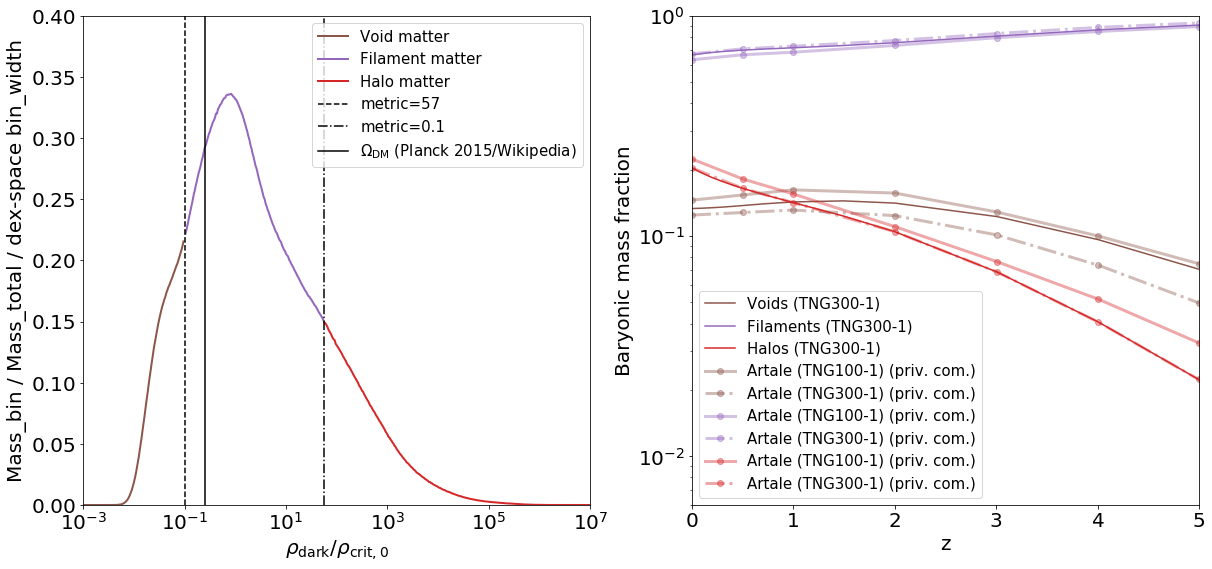

In [55]:
fig = plt.figure(figsize=(20,9))

ax1=fig.add_subplot(121)
ax1.set_ylabel('Mass_bin / Mass_total / dex-space bin_width',fontsize=20)
ax1.set_xlabel(r'$\rho_{\rm{dark}} / \rho_{\rm{crit,0}}$',fontsize=20)
ax.set_xscale('log')
ax1.set_xscale('log')
ax1.set_xlim([1e-3,1e7])
ax1.set_ylim([0,0.4])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

#get the indices of each LSS type so the curve can be coloured differently

voi_inds = (np.where(10**mybins<0.1))
fil_inds = (np.where((10**mybins>0.1) & (10**mybins<57)))
hal_inds = (np.where(10**mybins>57))

#ax1.plot(10**mybins,my_mass_sum/np.sum(my_mass_sum)/(mybins[1]-mybins[0]),label='binned baryonic matter')
ax1.plot(10**mybins[voi_inds],np.array(my_mass_sum/np.sum(my_mass_sum)/(mybins[1]-mybins[0]))[voi_inds],color='C5',linewidth=2,label='Void matter')
ax1.plot(10**mybins[fil_inds],np.array(my_mass_sum/np.sum(my_mass_sum)/(mybins[1]-mybins[0]))[fil_inds],color='C4',linewidth=2,label='Filament matter')
ax1.plot(10**mybins[hal_inds],np.array(my_mass_sum/np.sum(my_mass_sum)/(mybins[1]-mybins[0]))[hal_inds],color='C3',linewidth=2,label='Halo matter')



ax1.axvline(0.1,0,1,linestyle='--',color='k',label='metric=57')
ax1.axvline(57,0,1,linestyle='-.',color='k',label='metric=0.1')
ax1.axvline(0.2589,0,1,color='k',label=r'$\Omega_{\rm{DM}}$ (Planck 2015/Wikipedia)')

ax1.legend(fontsize=15)

ax2=fig.add_subplot(122)

ax2.set_xlabel('z',fontsize=20)
ax2.set_ylabel('Baryonic mass fraction',fontsize=20)
ax2.set_yscale('log')
ax2.set_ylim([6E-3,1])
ax2.set_xlim([0.,5.])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax2.plot((allsnaps_redshifts.mean(axis=1))[0:13],voi_frac[0:13],color='C5',label='Voids (TNG300-1)')
ax2.plot((allsnaps_redshifts.mean(axis=1))[0:13],fil_frac[0:13],color='C4',label='Filaments (TNG300-1)'.format(simString))
ax2.plot((allsnaps_redshifts.mean(axis=1))[0:13],hal_frac[0:13],color='C3',label='Halos (TNG300-1)'.format(simString))

ax2.plot(celeste_redshifts,V1001_mf,color='C5',marker='o',lw='3',alpha=0.4,label='Artale (TNG100-1) (priv. com.)')
ax2.plot(celeste_redshifts,V3001_mf,color='C5',marker='o',ls='-.',alpha=0.4,lw='3',label='Artale (TNG300-1) (priv. com.)')

ax2.plot(celeste_redshifts,F1001_mf,color='C4',marker='o',lw='3',alpha=0.4,label='Artale (TNG100-1) (priv. com.)')
ax2.plot(celeste_redshifts,F3001_mf,color='C4',marker='o',ls='-.',alpha=0.4,lw='3',label='Artale (TNG300-1) (priv. com.)')

ax2.plot(celeste_redshifts,H1001_mf,color='C3',marker='o',lw='3',alpha=0.4,label='Artale (TNG100-1) (priv. com.)')
ax2.plot(celeste_redshifts,H3001_mf,color='C3',marker='o',ls='-.',alpha=0.4,lw='3',label='Artale (TNG300-1) (priv. com.)')





ax2.legend(fontsize=15)


plt.tight_layout
plt.savefig('Paper_Plot_Structure_Metric.png')
plt.show()

In [56]:
print(10**mybins)


[1.00000000e-03 1.04712855e-03 1.09647820e-03 1.14815362e-03
 1.20226443e-03 1.25892541e-03 1.31825674e-03 1.38038426e-03
 1.44543977e-03 1.51356125e-03 1.58489319e-03 1.65958691e-03
 1.73780083e-03 1.81970086e-03 1.90546072e-03 1.99526231e-03
 2.08929613e-03 2.18776162e-03 2.29086765e-03 2.39883292e-03
 2.51188643e-03 2.63026799e-03 2.75422870e-03 2.88403150e-03
 3.01995172e-03 3.16227766e-03 3.31131121e-03 3.46736850e-03
 3.63078055e-03 3.80189396e-03 3.98107171e-03 4.16869383e-03
 4.36515832e-03 4.57088190e-03 4.78630092e-03 5.01187234e-03
 5.24807460e-03 5.49540874e-03 5.75439937e-03 6.02559586e-03
 6.30957344e-03 6.60693448e-03 6.91830971e-03 7.24435960e-03
 7.58577575e-03 7.94328235e-03 8.31763771e-03 8.70963590e-03
 9.12010839e-03 9.54992586e-03 1.00000000e-02 1.04712855e-02
 1.09647820e-02 1.14815362e-02 1.20226443e-02 1.25892541e-02
 1.31825674e-02 1.38038426e-02 1.44543977e-02 1.51356125e-02
 1.58489319e-02 1.65958691e-02 1.73780083e-02 1.81970086e-02
 1.90546072e-02 1.995262

# plot slices through the simulation

In [57]:
#create a voids filter

def _void_filter(pfilter,data):
    filter=data[pfilter.filtered_type,"SubfindDMDensity"]*(TNG_ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit)<0.1
    return filter
yt.add_particle_filter("my_voids",function=_void_filter,requires=["SubfindDMDensity"],filtered_type='PartType0')

TNG_ds.add_particle_filter('my_voids')

yt : [WARNING  ] 2023-03-25 15:02:56,187 The my_voids particle filter already exists. Overriding.
yt : [WARNING  ] 2023-03-25 15:02:56,191 It appears that you are filtering on an SPH field type. It is recommended to use 'gas' as the filtered particle type in this case instead.


True

In [58]:
#create a filaments filter

#filmask  = np.where((dark_units>=0.1) & (dark_units<57))
def _filament_filter(pfilter,data):
    dark_dens = data[pfilter.filtered_type,"SubfindDMDensity"]*(TNG_ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit)
    filter=np.logical_and(dark_dens >= 0.1, dark_dens < 57)
    return filter
yt.add_particle_filter("my_filaments",function=_filament_filter,requires=["SubfindDMDensity"],filtered_type='PartType0')

TNG_ds.add_particle_filter('my_filaments')

yt : [WARNING  ] 2023-03-25 15:02:56,512 The my_filaments particle filter already exists. Overriding.
yt : [WARNING  ] 2023-03-25 15:02:56,515 It appears that you are filtering on an SPH field type. It is recommended to use 'gas' as the filtered particle type in this case instead.


True

In [59]:
#create a halos filter

def _halo_filter(pfilter,data):
    filter=data[pfilter.filtered_type,"SubfindDMDensity"]*(TNG_ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit)>=57
    return filter
yt.add_particle_filter("my_halos",function=_halo_filter,requires=["SubfindDMDensity"],filtered_type='PartType0')

TNG_ds.add_particle_filter('my_halos')

yt : [WARNING  ] 2023-03-25 15:02:56,830 The my_halos particle filter already exists. Overriding.
yt : [WARNING  ] 2023-03-25 15:02:56,833 It appears that you are filtering on an SPH field type. It is recommended to use 'gas' as the filtered particle type in this case instead.


True

# Plotting tests

In [60]:
#pixelize a slice through the simulation
#(see https://yt-project.org/doc/analyzing/generating_processed_data.html for more info)

#sl=TNG_ds.slice(0,0.5)
#frb = FRB(sl, (0, 1, 0, 1), (512, 512))
#my_image = frb["density"]

In [61]:
#create fixed resolution buffer of slice (centered at 0.5 code units) of resolution 1024x1024
#https://yt-project.org/doc/analyzing/objects.html

frb = TNG_ds.r[0.5, ::1024j, ::1024j]

In [62]:
#extract arrays for the structures
#https://yt-project.org/doc/analyzing/objects.html 

my_hals = frb[('my_halos','density')]
my_fils = frb[('my_filaments','density')]
my_vois = frb[('my_voids','density')]


yt : [INFO     ] 2023-03-25 15:02:57,168 Making a fixed resolution buffer of (('my_halos', 'density')) 1024 by 1024
yt : [INFO     ] 2023-03-25 15:21:33,157 Making a fixed resolution buffer of (('my_filaments', 'density')) 1024 by 1024
yt : [INFO     ] 2023-03-25 15:38:28,361 Making a fixed resolution buffer of (('my_voids', 'density')) 1024 by 1024


In [63]:
tot_dens = frb[('PartType0','Density')]

yt : [INFO     ] 2023-03-25 15:55:11,077 Making a fixed resolution buffer of (('PartType0', 'Density')) 1024 by 1024


In [64]:
my_hals = frb[('my_halos','Density')]
my_fils = frb[('my_filaments','Density')]
my_vois = frb[('my_voids','Density')]

yt : [INFO     ] 2023-03-25 16:11:02,499 Making a fixed resolution buffer of (('my_halos', 'Density')) 1024 by 1024
yt : [INFO     ] 2023-03-25 16:28:10,658 Making a fixed resolution buffer of (('my_filaments', 'Density')) 1024 by 1024
yt : [INFO     ] 2023-03-25 16:45:25,450 Making a fixed resolution buffer of (('my_voids', 'Density')) 1024 by 1024


In [65]:
#examine output

print(my_hals,np.max(my_hals),np.min(my_hals))



[[7.39990729e-11 7.45061407e-11 7.60753926e-11 ... 7.09635309e-11
  7.26138392e-11 7.35925975e-11]
 [7.62862692e-11 7.74290158e-11 7.95076569e-11 ... 7.27046159e-11
  7.44957584e-11 7.56201287e-11]
 [7.93069383e-11 8.00104753e-11 8.12718342e-11 ... 7.55376759e-11
  7.75073395e-11 7.86896490e-11]
 ...
 [7.36727001e-11 7.18602032e-11 6.91554540e-11 ... 7.25868639e-11
  7.37310530e-11 7.42541817e-11]
 [7.33408430e-11 7.21452634e-11 7.03276170e-11 ... 7.12999154e-11
  7.27456266e-11 7.35214917e-11]
 [7.32362958e-11 7.27444454e-11 7.25231898e-11 ... 7.06388506e-11
  7.22175076e-11 7.31221580e-11]] code_mass/code_length**3 6.42310732091695e-05 code_mass/code_length**3 3.133295892480472e-11 code_mass/code_length**3


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/mpcdf/soft/SLE_15/packages/

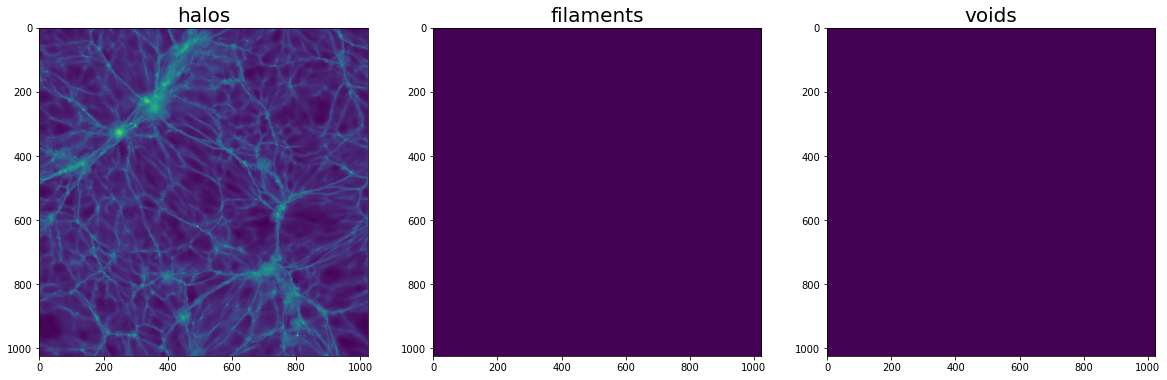

In [66]:
#plot the slice s a function of structure
fig = plt.figure(figsize=(20,9))
ax1=fig.add_subplot(131)
ax1.set_title('halos',fontsize=20)
ax1.imshow(my_hals.value,norm=LogNorm())
ax2=fig.add_subplot(132)
ax2.set_title('filaments',fontsize=20)
ax2.imshow(my_fils.value,norm=LogNorm())
ax3=fig.add_subplot(133)
ax3.set_title('voids',fontsize=20)
ax3.imshow(my_vois.value,norm=LogNorm())

In [67]:
#create blank maps
blank_hal = np.zeros_like(my_hals)
blank_fil = np.zeros_like(my_fils)
blank_voi = np.zeros_like(my_hals)

#fill in binary values where each LSS type lies
blank_hal[np.where(my_hals>0)]=1.
blank_fil[np.where(my_fils>0)]=1.
blank_voi[np.where(my_vois>0)]=1.

print(blank_hal)
print(blank_fil)
print(blank_voi)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]] code_mass/code_length**3
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] code_mass/code_length**3
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] code_mass/code_length**3


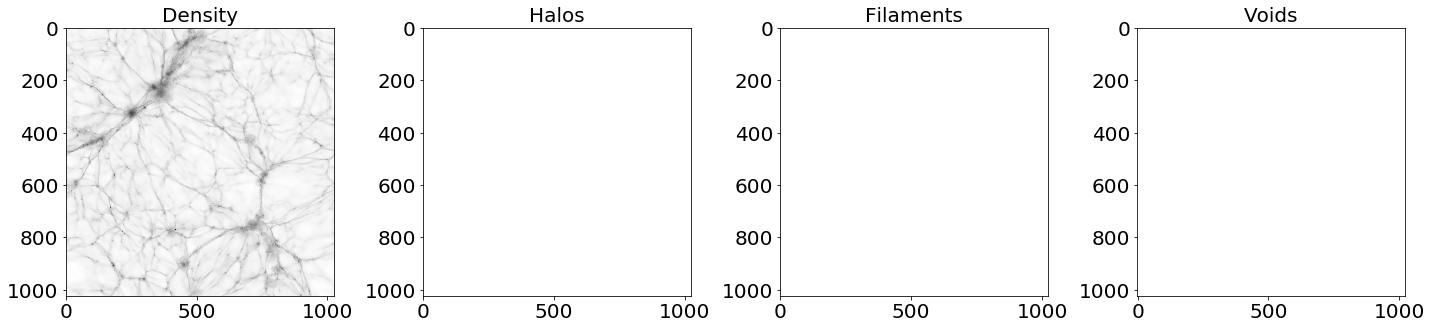

In [68]:
#plot the slice s a function of structure
fig = plt.figure(figsize=(20,9))

ax1=fig.add_subplot(141)
ax1.set_title('Density',fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


im = ax1.imshow(tot_dens.value,norm=LogNorm(), cmap=plt.cm.Greys)
#plt.colorbar(im)


ax2=fig.add_subplot(142)
ax2.set_title('Halos',fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax2.imshow(blank_hal.value, cmap = matplotlib.colors.ListedColormap(['white', 'C3']))

ax3=fig.add_subplot(143)
ax3.set_title('Filaments',fontsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

ax3.imshow(blank_fil.value, cmap = matplotlib.colors.ListedColormap(['white', 'C4']))

ax4=fig.add_subplot(144)
ax4.set_title('Voids',fontsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax4.imshow(blank_voi.value, cmap = matplotlib.colors.ListedColormap(['white', 'C5']))

plt.tight_layout()
plt.savefig('Paper_Plot_Structure_Breakdown.png',bbox_inches='tight',pad_inches = 0,)
plt.show()


[0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.5]


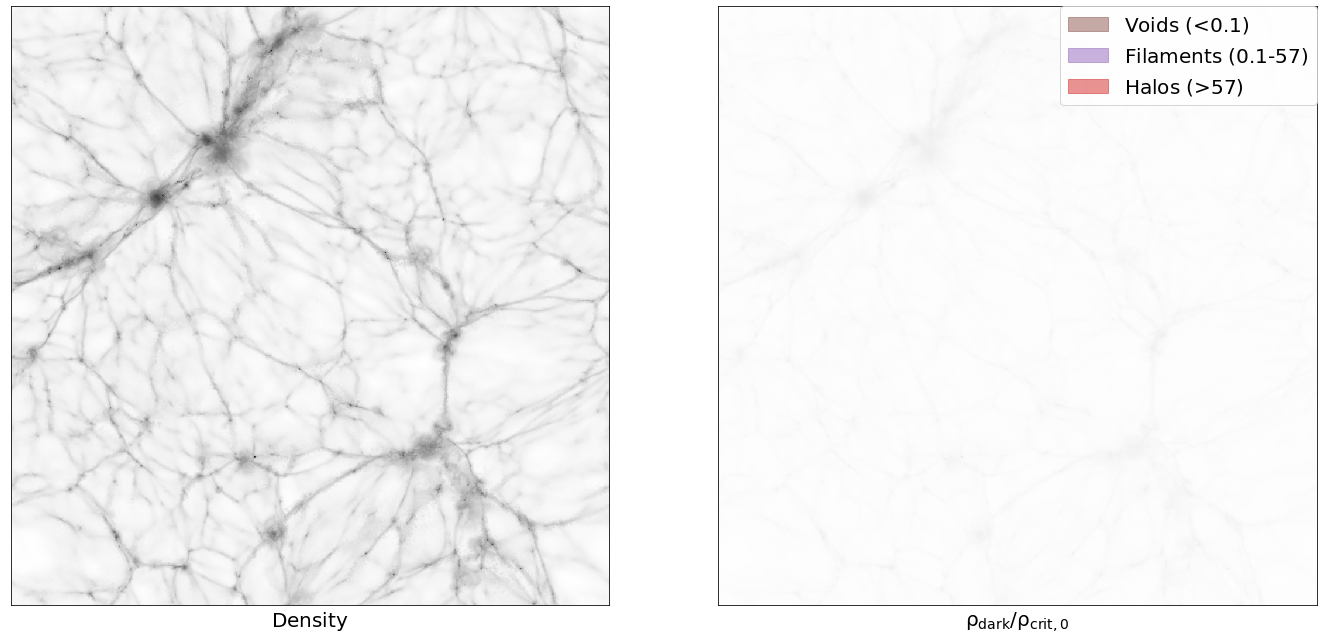

In [69]:
##### plot the slice s a function of structure
fig = plt.figure(figsize=(20,9))

ax1=fig.add_subplot(121)
#ax1.set_title('Density',fontsize=20)
ax1.set_xlabel(r'$\rm{Density}$',fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


im = ax1.imshow(tot_dens.value,norm=LogNorm(), cmap=plt.cm.Greys)

ax2=fig.add_subplot(122)
#ax2.set_title('Density',fontsize=20)
ax2.set_xlabel(r'$\rm{\rho_{dark}/\rho_{crit,0}}$',fontsize=20)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

alphaval=0.5
#colors translated from hex to rgb with:
#https://www.rapidtables.com/convert/color/hex-to-rgb.html
#and
#https://stackoverflow.com/questions/64369710/what-are-the-hex-codes-of-matplotlib-tab10-palette
print()
c3_hex = list(matplotlib.colors.to_rgb('C3'))
c3_hex.append(alphaval)
c4_hex = list(matplotlib.colors.to_rgb('C4'))
c4_hex.append(alphaval)
c5_hex = list(matplotlib.colors.to_rgb('C5'))
c5_hex.append(alphaval)

print(c3_hex)

#define labels for imshow 
#(source: https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib)
cmap = {1:c5_hex,2:c4_hex,3:c3_hex}
labels = {1:r'$\rm{Voids}$ (<0.1)',2:r'$\rm{Filaments}$ (0.1-57)',3:r'$\rm{Halos}$ (>57)'}
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

im2 = ax2.imshow(tot_dens.value,norm=LogNorm(), cmap=plt.cm.Greys)

ax2.imshow(blank_voi.value, cmap = matplotlib.colors.ListedColormap(['white', 'C5']),alpha=0.6)
ax2.imshow(blank_fil.value, cmap = matplotlib.colors.ListedColormap(['white', 'C4']),alpha=0.5)
ax2.imshow(blank_hal.value, cmap = matplotlib.colors.ListedColormap(['white', 'C3']),alpha=0.5)

ax2.legend(handles=patches, loc=1, borderaxespad=0.,fontsize=20)

plt.tight_layout()
plt.savefig('Paper_Plot_Structure_Breakdown.png')
plt.show()

In [70]:
print('hello')

hello
